In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.analysis.maths as imath
from iris.pandas import as_data_frame
import esem

import numpy as np
import pandas as pd
# from eofs.iris import Eof

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


In [3]:
from iris.cube import CubeList
# Get one combined historical + ssp585 timeseries for now
X = (iris.load('inputs_historical.nc') + iris.load('inputs_ssp585.nc')).concatenate()
# Just take the 1st ensemble member for this scenario
Y = CubeList([c[0] for c in iris.load('outputs_historical.nc') + iris.load('outputs_ssp585.nc')]).concatenate()


In [4]:
# Get the test data (NOT visible to contestants)

test_Y = iris.load('outputs_ssp245.nc')
test_X = iris.load('inputs_ssp245.nc')


# Input dimensionality reduction

For this baseline example I've decided to only take the leading few EOFs of the aerosol emissions data using the `eofs` package.

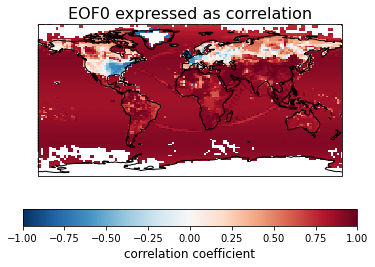

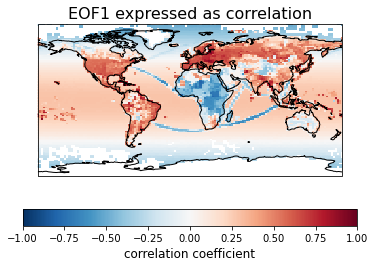

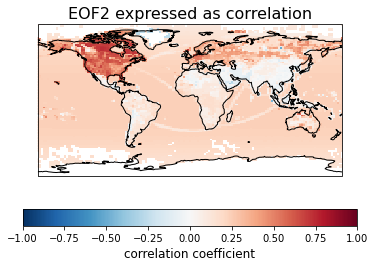

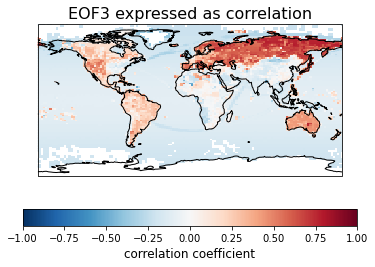

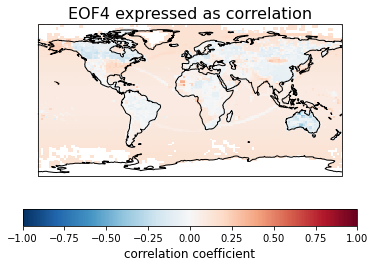

In [5]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(X.extract_cube('BC'), weights='coslat')

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

for eof in bc_eofs.slices_over('eof_number'):
    # Plot the leading EOF expressed as correlation in the Pacific domain.
    clevs = np.linspace(-1, 1, 11)
    ax = plt.axes(projection=ccrs.PlateCarree())
    fill = iplt.pcolormesh(eof, cmap=plt.cm.RdBu_r, vmin=-1., vmax=1.)
    ax.coastlines()
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title(f"EOF{eof.coord('eof_number').points[0]} expressed as correlation", fontsize=16)
    plt.show()

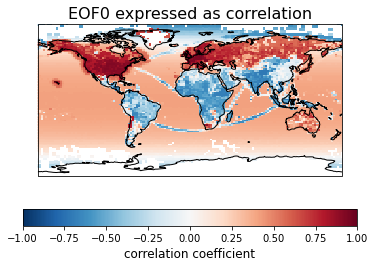

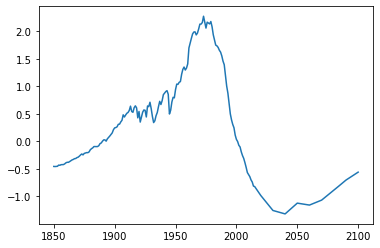

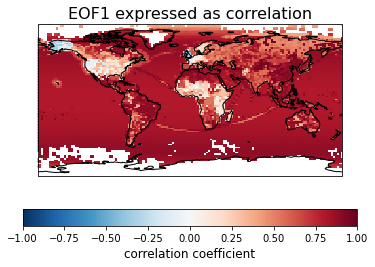

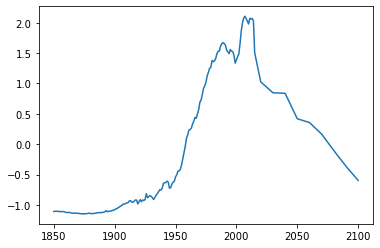

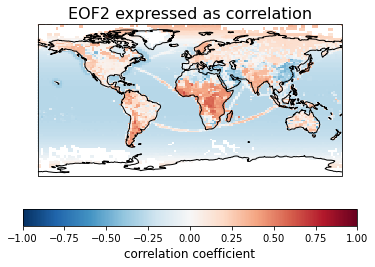

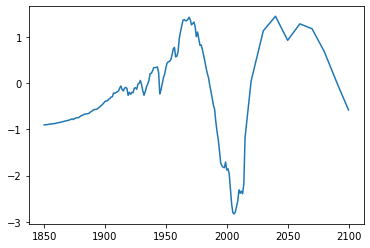

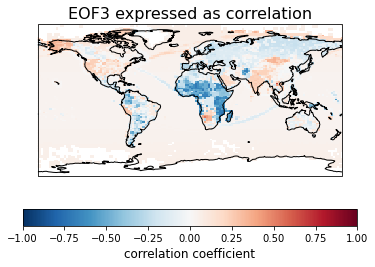

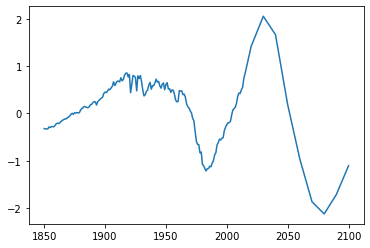

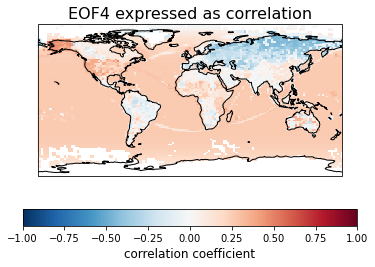

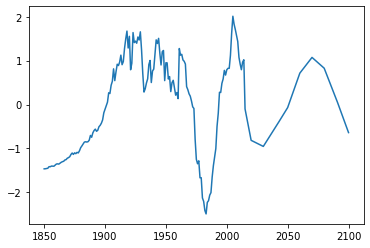

In [6]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
so2_solver = Eof(X.extract_cube('SO2'), weights='coslat')

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

for eof, pc in zip(so2_eofs.slices_over('eof_number'), so2_pcs.slices_over('pc_number')):
    # Plot the leading EOF expressed as correlation in the Pacific domain.
    clevs = np.linspace(-1, 1, 11)
    ax = plt.axes(projection=ccrs.PlateCarree())
    fill = iplt.pcolormesh(eof, cmap=plt.cm.RdBu_r, vmin=-1., vmax=1.)
    ax.coastlines()
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title(f"EOF{eof.coord('eof_number').points[0]} expressed as correlation", fontsize=16)
    plt.show()
    iplt.plot(pc)
    plt.show()

In [9]:
def func(i):
    ax = plt.axes(projection=ccrs.PlateCarree())
    iplt.pcolormesh(Y.extract_cube("tas").extract(iris.Constraint(time=i)), vmin=-2, vmax=2, cmap='RdBu_r')
    ax.coastlines()
    plt.colorbar()
    plt.show()
    
interact(func,i=IntSlider(min=1850, max=2014, step=1, continuous_update=False));

interactive(children=(IntSlider(value=1850, continuous_update=False, description='i', max=2014, min=1850), Out…

In [10]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = as_data_frame(bc_pcs)
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = as_data_frame(so2_pcs)
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [11]:
# Bring the emissions data back together again
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(X.extract_cube("CO2").data),
    "CH4": normalize_ch4(X.extract_cube("CH4").data)
}, index=X.extract_cube("CO2").coord('time').points)
# Normalize
# leading_historical_inputs=(leading_historical_inputs-leading_historical_inputs.mean())/leading_historical_inputs.std()

# Combine with aerosol EOFs
leading_historical_inputs=pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1)

In [12]:
leading_historical_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
1850,0.000078,0.052177,-0.938933,-0.303008,-2.110512,-0.056833,-0.387423,-0.453922,-1.108199,-0.903021,-0.318372,-1.465730
1851,0.000157,0.052903,-0.938544,-0.303702,-2.110510,-0.028309,-0.332906,-0.455768,-1.105076,-0.901621,-0.326058,-1.463670
1852,0.000239,0.053630,-0.942127,-0.298030,-2.075049,-0.040304,-0.319768,-0.453201,-1.104211,-0.898274,-0.325703,-1.458513
1853,0.000325,0.054356,-0.945680,-0.292218,-2.039420,-0.051443,-0.303067,-0.451375,-1.103392,-0.896136,-0.325204,-1.452164
1854,0.000425,0.055082,-0.967024,-0.260568,-1.849944,-0.243489,-0.441511,-0.429659,-1.111641,-0.887523,-0.284457,-1.416092
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,0.969970,0.796235,-0.289085,-1.184172,-1.637582,1.052569,-0.466145,-0.615274,-0.503373,-0.334003,-1.346945,-0.335547
2097,0.975296,0.791031,-0.331074,-1.149814,-1.751138,1.076268,-0.509963,-0.600865,-0.526479,-0.395502,-1.286171,-0.411541
2098,0.980621,0.785826,-0.373064,-1.115455,-1.864694,1.099966,-0.553782,-0.586455,-0.549585,-0.457000,-1.225398,-0.487536
2099,0.985947,0.780622,-0.415054,-1.081096,-1.978251,1.123665,-0.597601,-0.572045,-0.572692,-0.518499,-1.164624,-0.563530


# Build baseline model

In [13]:
from esem import gp_model, Whiten

# Just a *very* simple GP with default kernel assuming all years are independant

tas_gp = gp_model(leading_historical_inputs, Y.extract_cube("tas"))
tas_gp.train()

2021-08-13 17:04:02.806016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-13 17:04:02.806067: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-13 17:04:02.806094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host595.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist
2021-08-13 17:04:02.806591: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-13 17:04:02.847717: W tensorflow/python/util/util.cc:348] Sets are not currently considered seq

In [14]:

pr_gp = gp_model(leading_historical_inputs, Y.extract_cube("pr"), data_processors=[Whiten()])
pr_gp.train()

## Gather the test data

In [15]:
# Will be hidden from contestants
tas_truth = test_Y.extract_cube("tas").collapsed(['member'], iris.analysis.MEAN)
pr_truth = test_Y.extract_cube("pr").collapsed(['member'], iris.analysis.MEAN)

In [16]:
test_inputs = pd.DataFrame({
    "CO2": normalize_co2(test_X.extract_cube("CO2").data),
    "CH4": normalize_ch4(test_X.extract_cube("CH4").data),
}, index=test_X.extract_cube("CO2").coord('time').points)
# Normalize
# leading_historical_inputs=(leading_historical_inputs-leading_historical_inputs.mean())/leading_historical_inputs.std()

# Combine with aerosol EOFs
test_inputs=pd.concat([test_inputs, 
                       as_data_frame(bc_solver.projectField(test_X.extract_cube("BC"), neofs=5, eofscaling=1)).rename(columns={i:f"BC_{i}" for i in range(5)}),
                       as_data_frame(so2_solver.projectField(test_X.extract_cube("SO2"), neofs=5, eofscaling=1)).rename(columns={i:f"_{i}" for i in range(5)}),
                       ], axis=1)

# Evaluate predictions

In [17]:
m_tas, _ = tas_gp.predict(test_inputs.values)

In [18]:
m_pr, _ = pr_gp.predict(test_inputs.values)

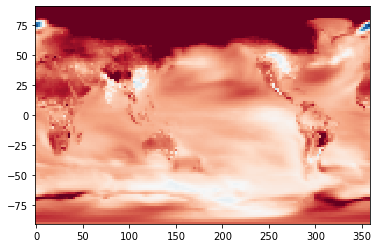

In [19]:
iplt.pcolormesh(m_tas[0], vmin=-2, vmax=2, cmap='RdBu_r')

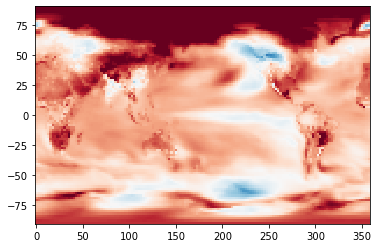

In [20]:
iplt.pcolormesh(tas_truth[0], vmin=-2, vmax=2, cmap='RdBu_r')

### These are the metrics to be scored on

In [21]:
def get_weights(cube):
    # Iris is pretty fussy...
    cube_ = cube.copy()
    if cube_.coords('lat'):
        cube_.coord('lat').rename('latitude')
    if cube_.coords('lon'):
        cube_.coord('lon').rename('longitude')
    if not cube_.coord('latitude').has_bounds():
        cube_.coord('latitude').guess_bounds()
    if not cube_.coord('longitude').has_bounds():
        cube_.coord('longitude').guess_bounds()
    if cube_.coord('latitude').units == 'unknown':
        cube_.coord('latitude').units = 'degrees'
    if cube_.coord('longitude').units == 'unknown':
        cube_.coord('longitude').units = 'degrees'
    return iris.analysis.cartography.area_weights(cube_)

def get_rmse(truth, pred):
    return (truth-pred).collapsed(['lat', 'lon'], iris.analysis.RMS, weights=get_weights(truth)).data

print(f"RMSE at 2015: {get_rmse(tas_truth[0], m_tas[0])}")
print(f"RMSE at 2050: {get_rmse(tas_truth[35], m_tas[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], m_tas[85])}")

RMSE at 2015: 0.456011535679394
RMSE at 2050: 0.3293404454008044
RMSE at 2100: 0.46112380421901544


In [22]:
print(f"RMSE at 2015: {get_rmse(pr_truth[0], m_pr[0])}")
print(f"RMSE at 2050: {get_rmse(pr_truth[35], m_pr[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], m_pr[85])}")

RMSE at 2015: 4.360790358514709e-06
RMSE at 2050: 4.9854200222103434e-06
RMSE at 2100: 6.865851476974105e-06
